In [2]:
import torch
from torch import nn 
from torch.nn import functional as F
import utils

def train(model, train_iter, test_iter, lr, epochs, device):
    # Parameters Initialization
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weights)
    print('train on', device)
    model.to(device)
    
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    
    train_metric = utils.Accumulator(3)
    test_metric = utils.Accumulator(3)
    
    loss_rec = utils.EpochRecorder(2)
    acc_rec = utils.EpochRecorder(2)
    
    for epoch in range(epochs):
        train_metric.reset()
        test_metric.reset()
        
        model.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_metric.add(float(l * y.numel()), utils.accuracy(y_hat, y), y.numel())
        
        model.eval()
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                l = loss(y_hat, y)
                test_metric.add(float(l * y.numel()), utils.accuracy(y_hat, y), y.numel())                            

        train_l, train_acc = train_metric[0] / train_metric[2], train_metric[1] / train_metric[2]
        test_l, test_acc = test_metric[0] / test_metric[2], test_metric[1] / test_metric[2]
        
        loss_rec.append(train_l, test_l)
        acc_rec.append(train_acc, test_acc)
        
        print('epoch: {}, train loss: {:.3f}, train acc: {:.3f}, test loss: {:.3f}, test acc: {:.3f}'.format(
            epoch, train_l, train_acc, test_l, test_acc
        ))       
        
    return loss_rec, acc_rec

### LeNet

Model

In [4]:
batch_size = 256
train_iter, test_iter = utils.load_fashion_mnist(batch_size)

LeNet = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

print('##########################################################################')
X = torch.randn((1, 1, 28, 28))
for layer in LeNet:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape) 
print('##########################################################################')

epochs, lr = 10, 0.9
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loss_rec, acc_rec = train(LeNet, train_iter, test_iter, lr, epochs, device)

##########################################################################
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])
##########################################################################
train on cuda
epoch: 0, train loss: 2.320, train acc: 0.101, test loss: 2.305, test acc: 0.100
epoch: 1, train loss: 1.994, train acc: 0.229, test loss: 1.155, test acc: 0.517
epoch: 2, train loss: 0.970, train acc: 0.613, test loss: 0.896, test acc: 0.656
epoch: 3, train loss

Metric

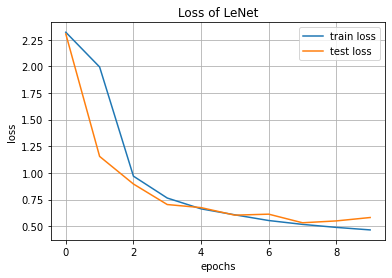

In [5]:
loss_rec.plot(labels=('train loss', 'test loss'), ylabel = 'loss', title = 'Loss of LeNet')

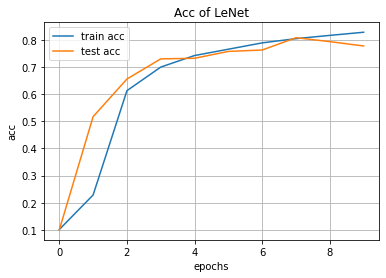

In [6]:
acc_rec.plot(labels=('train acc', 'test acc'), ylabel = 'acc', title = 'Acc of LeNet')

### AlexNet

Model

In [11]:
batch_size, resize = 128, 224
train_iter, test_iter = utils.load_fashion_mnist(batch_size, resize)

AlexNet = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)

print('##########################################################################')
X = torch.randn((1, 1, 224, 224))
for layer in AlexNet:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape) 
print('##########################################################################')

epochs, lr = 10, 0.01
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loss_rec, acc_rec = train(AlexNet, train_iter, test_iter, lr, epochs, device)

##########################################################################
Conv2d output shape: 	 torch.Size([1, 96, 54, 54])
ReLU output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape: 	 torch.Size([1, 96, 26, 26])
Conv2d output shape: 	 torch.Size([1, 256, 26, 26])
ReLU output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape: 	 torch.Size([1, 256, 12, 12])
Conv2d output shape: 	 torch.Size([1, 384, 12, 12])
ReLU output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d output shape: 	 torch.Size([1, 384, 12, 12])
ReLU output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d output shape: 	 torch.Size([1, 256, 12, 12])
ReLU output shape: 	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape: 	 torch.Size([1, 256, 5, 5])
Flatten output shape: 	 torch.Size([1, 6400])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Siz

Metric

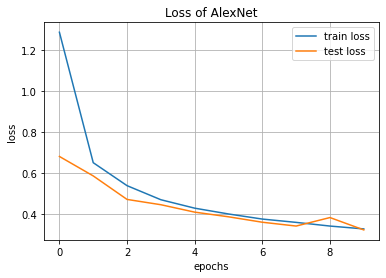

In [12]:
loss_rec.plot(labels=('train loss', 'test loss'), ylabel = 'loss', title = 'Loss of AlexNet')

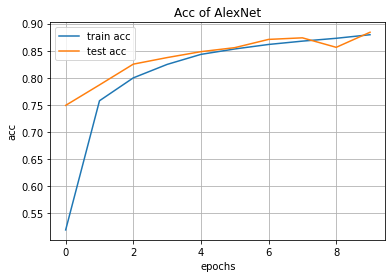

In [13]:
acc_rec.plot(labels=('train acc', 'test acc'), ylabel = 'acc', title = 'Acc of AlexNet')

### VGG

In [14]:
def VGG_Block(num_convs, num_in, num_out):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(num_in, num_out, kernel_size = 3, padding = 1))
        layers.append(nn.ReLU())
        num_in = num_out
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

def VGG(conv_arch):
    conv_blks = []
    num_in = 1
    for num_convs, num_out in conv_arch:
        conv_blks.append(VGG_Block(num_convs, num_in, num_out))
        num_in = num_out
        
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.Linear(num_out * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )

In [17]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
VGG11 = VGG(conv_arch)

X = torch.randn((1, 1, 224, 224))
for blk in VGG11:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [21]:
batch_size, resize = 128, 224
train_iter, test_iter = utils.load_fashion_mnist(batch_size, resize)

ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
VGG11_test = VGG(small_conv_arch)

epochs, lr = 10, 0.05
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loss_rec, acc_rec = train(VGG11_test, train_iter, test_iter, lr, epochs, device)

train on cuda
epoch: 0, train loss: 0.922, train acc: 0.660, test loss: 0.426, test acc: 0.847
epoch: 1, train loss: 0.404, train acc: 0.850, test loss: 0.343, test acc: 0.875
epoch: 2, train loss: 0.329, train acc: 0.879, test loss: 0.309, test acc: 0.884
epoch: 3, train loss: 0.289, train acc: 0.894, test loss: 0.298, test acc: 0.891
epoch: 4, train loss: 0.261, train acc: 0.903, test loss: 0.296, test acc: 0.898
epoch: 5, train loss: 0.239, train acc: 0.912, test loss: 0.247, test acc: 0.908
epoch: 6, train loss: 0.222, train acc: 0.919, test loss: 0.256, test acc: 0.907
epoch: 7, train loss: 0.205, train acc: 0.924, test loss: 0.257, test acc: 0.910
epoch: 8, train loss: 0.192, train acc: 0.929, test loss: 0.223, test acc: 0.920
epoch: 9, train loss: 0.176, train acc: 0.935, test loss: 0.229, test acc: 0.920


Metric

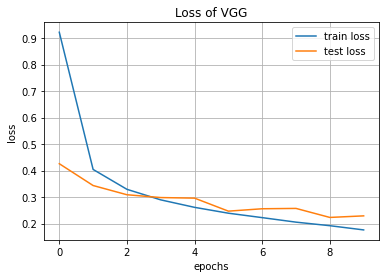

In [22]:
loss_rec.plot(labels=('train loss', 'test loss'), ylabel = 'loss', title = 'Loss of VGG')

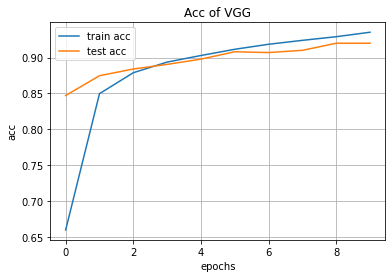

In [23]:
acc_rec.plot(labels=('train acc', 'test acc'), ylabel = 'acc', title = 'Acc of VGG')

### NiN

Model

In [25]:
batch_size, resize = 128, 224
train_iter, test_iter = utils.load_fashion_mnist(batch_size, resize)

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )
    
NiN = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

print('##########################################################################')
X = torch.rand(size=(1, 1, 224, 224))
for layer in NiN:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)
print('##########################################################################')

epochs, lr = 10, 0.01
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loss_rec, acc_rec = train(NiN, train_iter, test_iter, lr, epochs, device)

##########################################################################
Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])
##########################################################################
train on cuda
epoch: 0, train loss: 2.307, train acc: 0.100, test loss: 2.304, test acc: 0.100
epoch: 1, train loss: 2.303, train acc: 0.100, test loss: 2.303, test acc: 0.100
epoch: 2, train loss: 2.302, train acc: 0.100, test loss: 2.301, test acc: 0.100
epoch: 3, train loss: 2.300, train acc: 0.112, test loss: 2.298, t

Metric

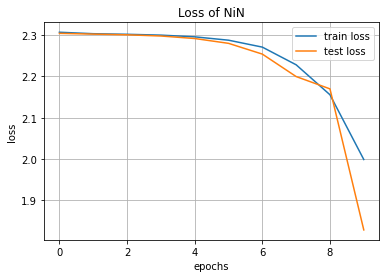

In [26]:
loss_rec.plot(labels=('train loss', 'test loss'), ylabel = 'loss', title = 'Loss of NiN')

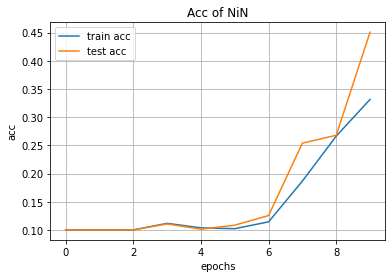

In [27]:
acc_rec.plot(labels=('train acc', 'test acc'), ylabel = 'acc', title = 'Acc of NiN')

### GoogLeNet

Model

In [32]:
batch_size, resize = 128, 96
train_iter, test_iter = utils.load_fashion_mnist(batch_size, resize)

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)
    
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())
GoogLeNet = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

print('##########################################################################')
X = torch.rand(size=(1, 1, 224, 224))
for layer in GoogLeNet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)
print('##########################################################################')

epochs, lr = 10, 0.01
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loss_rec, acc_rec = train(GoogLeNet, train_iter, test_iter, lr, epochs, device)

##########################################################################
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 192, 28, 28])
Sequential output shape:	 torch.Size([1, 480, 14, 14])
Sequential output shape:	 torch.Size([1, 832, 7, 7])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])
##########################################################################
train on cuda
epoch: 0, train loss: 2.302, train acc: 0.106, test loss: 2.301, test acc: 0.100
epoch: 1, train loss: 2.299, train acc: 0.164, test loss: 2.297, test acc: 0.271
epoch: 2, train loss: 2.291, train acc: 0.287, test loss: 2.279, test acc: 0.309
epoch: 3, train loss: 2.096, train acc: 0.294, test loss: 1.528, test acc: 0.425
epoch: 4, train loss: 1.170, train acc: 0.540, test loss: 0.894, test acc: 0.600
epoch: 5, train loss: 0.842, train acc: 0.675, test loss: 0.714, test acc: 0.733
epoch: 6, train loss: 0.661, train acc: 0.7

Metric

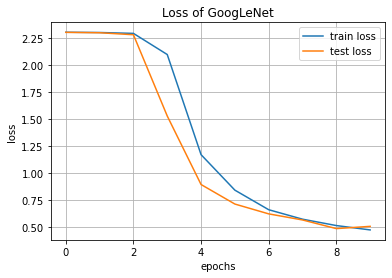

In [33]:
loss_rec.plot(labels=('train loss', 'test loss'), ylabel = 'loss', title = 'Loss of GoogLeNet')

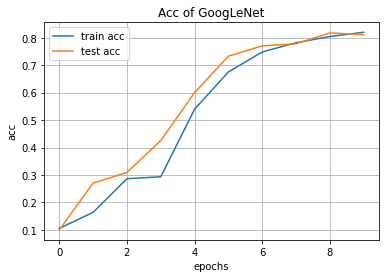

In [34]:
acc_rec.plot(labels=('train acc', 'test acc'), ylabel = 'acc', title = 'Acc of GoogLeNet')

### ResNet

Model

In [3]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, 
                 use_1x1conv = False, strides = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [4]:
batch_size, resize = 256, 96
train_iter, test_iter = utils.load_fashion_mnist(batch_size, resize)

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

ResNet = nn.Sequential(
    b1, b2, b3, b4, b5, 
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(), nn.Linear(512, 10)
)

print('##########################################################################')
X = torch.rand(size=(1, 1, 96, 96))
for layer in ResNet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)
print('##########################################################################')

epochs, lr = 10, 0.03
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loss_rec, acc_rec = train(ResNet, train_iter, test_iter, lr, epochs, device)

##########################################################################
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])
##########################################################################
train on cuda
epoch: 0, train loss: 0.458, train acc: 0.837, test loss: 0.452, test acc: 0.831
epoch: 1, train loss: 0.262, train acc: 0.903, test loss: 0.387, test acc: 0.861
epoch: 2, train loss: 0.199, train acc: 0.927, test loss: 0.311, test acc: 0.890
epoch: 3, train loss: 0.157, train acc: 0.943, test loss: 0.350, test acc: 0.875
epoch: 4, train loss: 0.117, train acc: 0.959, test loss: 0.360, test acc: 0.877
epoch: 5, train 

Metric

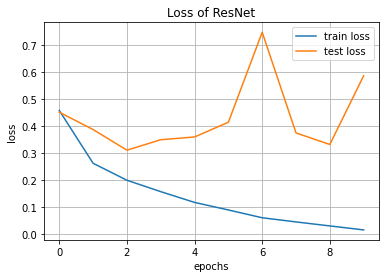

In [5]:
loss_rec.plot(labels=('train loss', 'test loss'), ylabel = 'loss', title = 'Loss of ResNet')

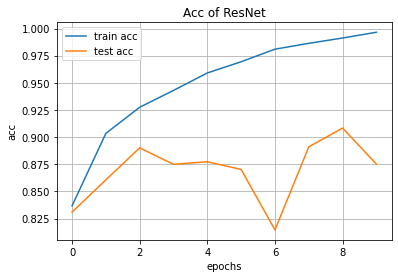

In [6]:
acc_rec.plot(labels=('train acc', 'test acc'), ylabel = 'acc', title = 'Acc of ResNet')

### DenseNet

In [7]:
batch_size, resize = 256, 96
train_iter, test_iter = utils.load_fashion_mnist(batch_size, resize)

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))
    
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2
DenseNet = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

print('##########################################################################')
X = torch.rand(size=(1, 1, 96, 96))
for layer in DenseNet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)
print('##########################################################################')

epochs, lr = 10, 0.03
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loss_rec, acc_rec = train(DenseNet, train_iter, test_iter, lr, epochs, device)

##########################################################################
Sequential output shape:	 torch.Size([1, 64, 24, 24])
DenseBlock output shape:	 torch.Size([1, 192, 24, 24])
Sequential output shape:	 torch.Size([1, 96, 12, 12])
DenseBlock output shape:	 torch.Size([1, 224, 12, 12])
Sequential output shape:	 torch.Size([1, 112, 6, 6])
DenseBlock output shape:	 torch.Size([1, 240, 6, 6])
Sequential output shape:	 torch.Size([1, 120, 3, 3])
DenseBlock output shape:	 torch.Size([1, 248, 3, 3])
BatchNorm2d output shape:	 torch.Size([1, 248, 3, 3])
ReLU output shape:	 torch.Size([1, 248, 3, 3])
AdaptiveMaxPool2d output shape:	 torch.Size([1, 248, 1, 1])
Flatten output shape:	 torch.Size([1, 248])
Linear output shape:	 torch.Size([1, 10])
##########################################################################
train on cuda
epoch: 0, train loss: 0.531, train acc: 0.812, test loss: 0.608, test acc: 0.791
epoch: 1, train loss: 0.312, train acc: 0.885, test loss: 0.363, test acc: 0.8

Metric

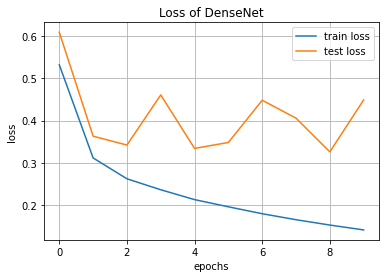

In [8]:
loss_rec.plot(labels=('train loss', 'test loss'), ylabel = 'loss', title = 'Loss of DenseNet')

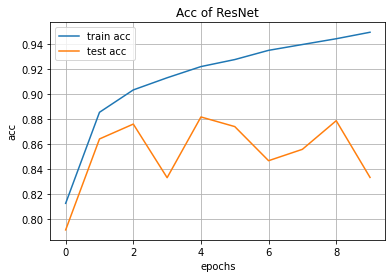

In [9]:
acc_rec.plot(labels=('train acc', 'test acc'), ylabel = 'acc', title = 'Acc of ResNet')